In [81]:
import numpy as np
import cv2

# 这个值越大越好
def spatial_correlation(img1, img2, threshold, bound):
    img1_threshold = threshold[0]
    img2_threshold = threshold[1]
    
    shape = img1.shape

    img1_cp = np.array(img1).astype(float)
    img2_cp = np.array(img2).astype(float)

    # 两张图片分别填充bound之外的值，从而容易筛选出我们想要的元素的个数
    img1_cp[img1 < img1_threshold] = 0
    img2_cp[img2 < img2_threshold] = 255

    lower_bound = bound[0]
    upper_bound = bound[1]

    diff_imgs = np.abs(img1_cp - img2_cp)
    count = np.sum((diff_imgs >= lower_bound) & (diff_imgs <= upper_bound))
    return count/(shape[0] * shape[1])


def normalized_cross_correlation(image1, image2):
    """计算两幅图像的归一化互相关(NCC)。"""
    if image1.shape != image2.shape:
        raise ValueError("图像必须有相同的尺寸。")

    mean1 = np.mean(image1)
    mean2 = np.mean(image2)

    std1 = np.std(image1)
    std2 = np.std(image2)

    ncc = np.sum((image1 - mean1) * (image2 - mean2)) / (std1 * std2 * np.size(image1))
    return ncc

import numpy as np

def calculate_entropy(hist):
    """根据直方图计算熵"""
    p = hist / hist.sum()
    p = p[p > 0] # 移除概率为0的项
    return -np.sum(p * np.log2(p))

def mutual_information(hgram):
    """根据联合直方图计算互信息"""
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1) # 对 y 求和
    py = np.sum(pxy, axis=0) # 对 x 求和
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log2(pxy[nzs] / px_py[nzs]))

def mutual_information_2(image1, image2, bins=256):
    # Calculate the histogram of the images, 这个hist_2d对应的z值是(intensity_1(image1的), intensity_2(image2的))对应出现的频率
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)

    # Calculate the joint probability distribution
    pxy = hist_2d / float(np.sum(hist_2d))
    px = np.sum(pxy, axis=1) # Marginal for x over y
    py = np.sum(pxy, axis=0) # Marginal for y over x

    # Calculate the mutual information
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0 # Non-zero joint probabilities
    mi = np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))

    return mi

def normalized_mutual_information(image1, image2, bins=256):
    """计算两幅图像的归一化互信息"""
    hist_2d, _, _ = np.histogram2d(image1.ravel(), image2.ravel(), bins=bins)
    
    # 计算互信息
    mi = mutual_information(hist_2d)

    # 计算图像的熵
    h1, _ = np.histogram(image1, bins=bins)
    h2, _ = np.histogram(image2, bins=bins)
    h1_entropy = calculate_entropy(h1)
    h2_entropy = calculate_entropy(h2)

    # 计算归一化互信息
    nmi = 2 * mi / (h1_entropy + h2_entropy)
    return nmi


ncc_bse_reg: 0.027167596084185206
ncc_bse_not_reg: 0.06004643818738749
ncc_bse_max_mi: 0.03017993565250902
5725124.0
5506445.0
7235721.0
nmi_bse_reg: 0.04124776278789072
nmi_bse_max_mi: 0.05625173720610789
nmi_bse_not_reg: 0.038271375060770205
mi_bse_reg: 0.2001328643985873
mi_bse_max_mi: 0.2602318737939322
mi_bse_not_reg: 0.18561345934274154
correlation between bse and reg_result: 0.06988542108714942
correlation between bse and max_mi: 0.050258477682188184
correlation between bse and nor_reg: 0.06631688592261101


(<Axes: title={'center': 'max_mi_ct_img'}>,
 Text(0.5, 1.0, 'max_mi_ct_img'))

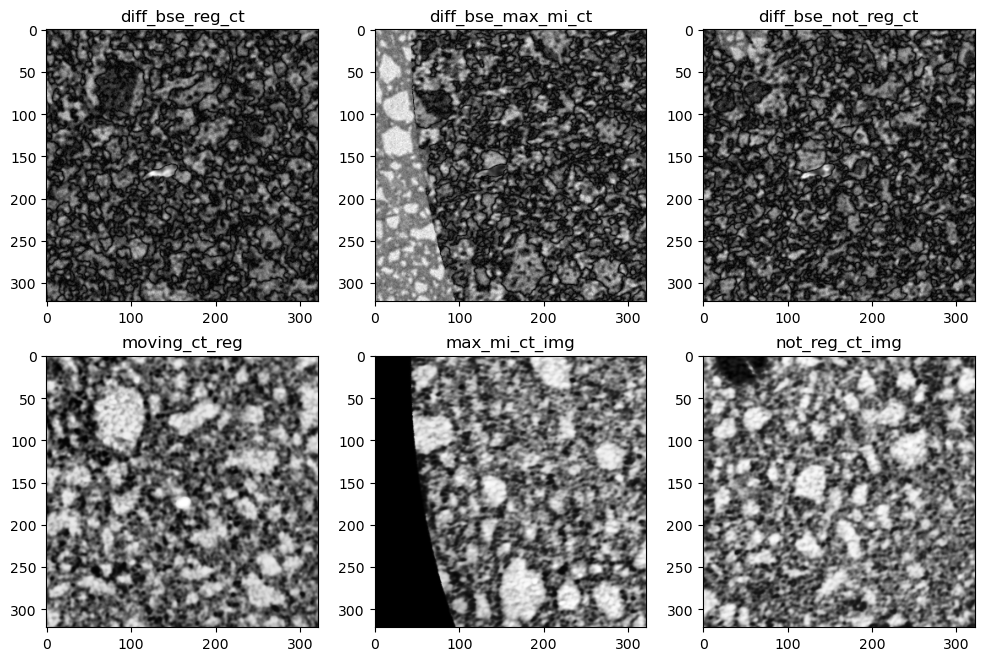

In [82]:
# MI结合空间信息

import numpy as np
import cv2
import matplotlib.pyplot as plt

fixed_bse_img = cv2.imread("spatial-correlation-statistics/bse_mini.bmp", cv2.IMREAD_GRAYSCALE)
moving_ct_reg = cv2.imread("spatial-correlation-statistics/ct_mini.bmp", cv2.IMREAD_GRAYSCALE)
max_mi_ct_img = cv2.imread("spatial-correlation-statistics/max_mi.bmp", cv2.IMREAD_GRAYSCALE)
not_reg_ct_img = cv2.imread("spatial-correlation-statistics/not_reg_result.bmp", cv2.IMREAD_GRAYSCALE)


# HACK 8位无符号整数溢出了
diff_bse_reg_ct = np.abs(fixed_bse_img.astype(float) - moving_ct_reg.astype(float))
diff_bse_max_mi_ct = np.abs(fixed_bse_img.astype(float) - max_mi_ct_img.astype(float))
diff_bse_not_reg_ct = np.abs(fixed_bse_img.astype(float) - not_reg_ct_img.astype(float))

ncc_bse_reg = normalized_cross_correlation(fixed_bse_img, moving_ct_reg)
ncc_bse_max_mi = normalized_cross_correlation(fixed_bse_img, max_mi_ct_img)
ncc_bse_not_reg = normalized_cross_correlation(fixed_bse_img, not_reg_ct_img)

nmi_bse_reg = normalized_mutual_information(fixed_bse_img, moving_ct_reg)
nmi_bse_max_mi = normalized_mutual_information(fixed_bse_img, max_mi_ct_img)
nmi_bse_not_reg = normalized_mutual_information(fixed_bse_img, not_reg_ct_img)

mi_bse_reg = mutual_information_2(fixed_bse_img, moving_ct_reg)
mi_bse_max_mi = mutual_information_2(fixed_bse_img, max_mi_ct_img)
mi_bse_not_reg = mutual_information_2(fixed_bse_img, not_reg_ct_img)


# HACK NCC没作用
print(f"ncc_bse_reg: {ncc_bse_reg}")
print(f"ncc_bse_not_reg: {ncc_bse_not_reg}")
print(f"ncc_bse_max_mi: {ncc_bse_max_mi}")
print(diff_bse_reg_ct.sum())
print(diff_bse_not_reg_ct.sum())
print(diff_bse_max_mi_ct.sum())
print(f"nmi_bse_reg: {nmi_bse_reg}")
print(f"nmi_bse_max_mi: {nmi_bse_max_mi}")
print(f"nmi_bse_not_reg: {nmi_bse_not_reg}")
print(f"mi_bse_reg: {mi_bse_reg}")
print(f"mi_bse_max_mi: {mi_bse_max_mi}")
print(f"mi_bse_not_reg: {mi_bse_not_reg}")

threshold = [128, 180]
bound = [0, 50]
print(f"correlation between bse and reg_result: {spatial_correlation(fixed_bse_img, moving_ct_reg, threshold, bound)}")
print(f"correlation between bse and max_mi: {spatial_correlation(fixed_bse_img, max_mi_ct_img, threshold, bound)}")
print(f"correlation between bse and nor_reg: {spatial_correlation(fixed_bse_img, not_reg_ct_img, threshold, bound)}")


plt.figure(figsize=(12, 12))
plt.subplot(3, 3, 1), plt.imshow(diff_bse_reg_ct, cmap='gray'), plt.title('diff_bse_reg_ct')
plt.subplot(3, 3, 2), plt.imshow(diff_bse_max_mi_ct, cmap='gray'), plt.title('diff_bse_max_mi_ct')
plt.subplot(3, 3, 3), plt.imshow(diff_bse_not_reg_ct, cmap='gray'), plt.title('diff_bse_not_reg_ct')
plt.subplot(3, 3, 4), plt.imshow(moving_ct_reg, cmap='gray'), plt.title('moving_ct_reg')
plt.subplot(3, 3, 6), plt.imshow(not_reg_ct_img, cmap='gray'), plt.title('not_reg_ct_img')
plt.subplot(3, 3, 5), plt.imshow(max_mi_ct_img, cmap='gray'), plt.title('max_mi_ct_img')


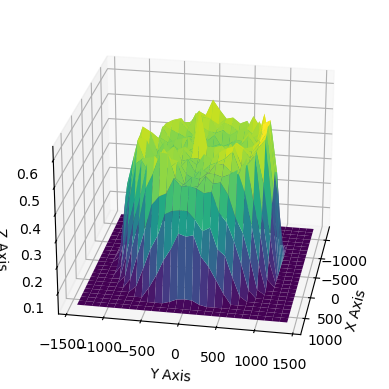

In [121]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

csv_prefix = "after_contrast_1200"

# 读取 CSV 文件到 DataFrame
mi_datas = pd.read_csv(f'saved_datas/{csv_prefix}mi_datas.csv')

# 从 DataFrame 中提取数据
x = mi_datas['x']
y = mi_datas['y']
z = mi_datas['w']

# 创建网格
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), len(np.unique(x))),
                   np.linspace(np.min(y), np.max(y), len(np.unique(y))))
Z = griddata((x, y), z, (X, Y), method='cubic')

# 绘制三维曲面
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 添加坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 设置视角
azimuth = 10  # 方位角，水平旋转的度数
elevation = 25  # 仰角，垂直旋转的度数
ax.view_init(elev=elevation, azim=azimuth)

plt.show()


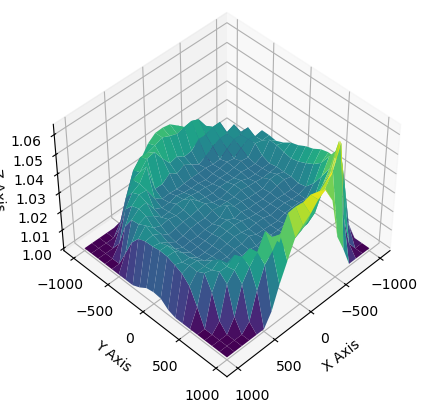

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

# 读取 CSV 文件到 DataFrame
mi_datas = pd.read_csv(f'saved_datas/{csv_prefix}nmi_datas.csv')

# 从 DataFrame 中提取数据
x = mi_datas['x']
y = mi_datas['y']
z = mi_datas['z']

# 创建网格
X, Y = np.meshgrid(np.linspace(np.min(x), np.max(x), len(np.unique(x))),
                   np.linspace(np.min(y), np.max(y), len(np.unique(y))))
Z = griddata((x, y), z, (X, Y), method='cubic')

# 绘制三维曲面
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')

# 添加坐标轴标签
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# 设置视角
azimuth = 45  # 方位角，水平旋转的度数
elevation = 45  # 仰角，垂直旋转的度数
ax.view_init(elev=elevation, azim=azimuth)

plt.show()
